# 📎 CNN for UTSTelkom Datasets - TensorFlow



> Training memakan waktu lama
> 1 Epoch 1 jam 30 menit wakakaak



## Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Datasets

Step 1: Data Collection and Preparation
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fish classes found: ['Bangus', 'Big Head Carp', 'Climbing Perch', 'Freshwater Eel', 'Grass Carp', 'Gold Fish', 'Goby', 'Fourfinger Threadfin', 'Gourami', 'Glass Perchlet', 'Catfish', 'Black Spotted Barb', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Long-Snouted Pipefish', 'Jaguar Gapote', 'Mosquito Fish', 'Janitor Fish', 'Mudfish', 'Knifefish', 'Mullet', 'Perch', 'Pangasius', 'Scat Fish', 'Silver Barb', 'Silver Perch', 'Snakehead', 'Silver Carp', 'Tilapia', 'Tenpounder']
Total number of classes: 31
Training images per class: {'Bangus': 171, 'Big Head Carp': 201, 'Climbing Perch': 151, 'Freshwater Eel': 271, 'Grass Carp': 1167, 'Gold Fish': 201, 'Goby': 604, 'Fourfinger Threadfin': 191, 'Gourami': 311, 'Glass Perchlet': 397, 'Catfish': 314, 'Black Spotted Barb': 200, 'Green Spotted Puffer': 110, 'India

<Figure size 1200x600 with 0 Axes>

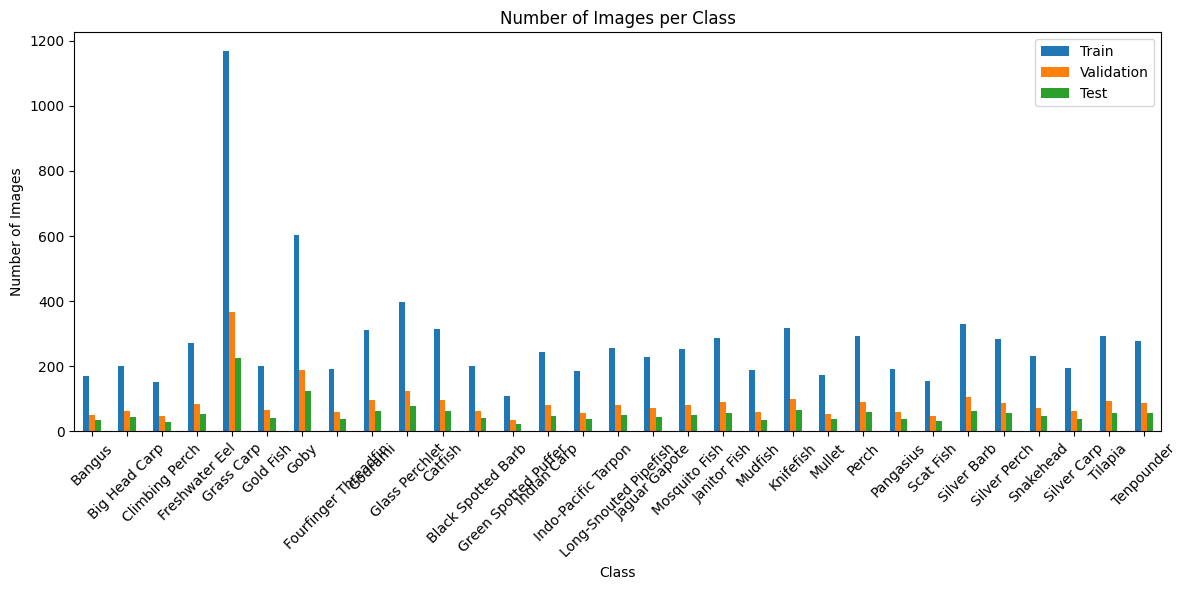

In [ ]:
# 1. Data Collection and Preparation
print("Step 1: Data Collection and Preparation")

# Define paths for datasets
train_dir = '/content/drive/MyDrive/DL/train'
val_dir = '/content/drive/MyDrive/DL/val'
test_dir = '/content/drive/MyDrive/DL/test'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# List the classes (fish types) in the dataset
classes = os.listdir(train_dir)
print(f"Fish classes found: {classes}")
num_classes = len(classes)
print(f"Total number of classes: {num_classes}")

# Check the number of images in each directory
def count_images(directory):
    counts = {}
    total = 0
    for cls in os.listdir(directory):
        cls_dir = os.path.join(directory, cls)
        if os.path.isdir(cls_dir):
            num_images = len([f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
            counts[cls] = num_images
            total += num_images
    return counts, total

train_counts, train_total = count_images(train_dir)
val_counts, val_total = count_images(val_dir)
test_counts, test_total = count_images(test_dir)

print(f"Training images per class: {train_counts}")
print(f"Total training images: {train_total}")
print(f"Validation images per class: {val_counts}")
print(f"Total validation images: {val_total}")
print(f"Test images per class: {test_counts}")
print(f"Total test images: {test_total}")

# Create a DataFrame to visualize class distribution
df_counts = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
})

# Plot class distribution
plt.figure(figsize=(12, 6))
df_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

## Preprocessing

In [ ]:
# 2. Data Preprocessing and Augmentation
print("\nStep 2: Data Preprocessing and Augmentation")

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets with generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices for mapping labels
class_indices = train_generator.class_indices
print(f"Class indices: {class_indices}")

# Reverse class indices for interpretation
class_names = {v: k for k, v in class_indices.items()}
print(f"Class names: {class_names}")


Step 2: Data Preprocessing and Augmentation
Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
Class indices: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito Fish': 19, 'Mudfish': 20, 'Mullet': 21, 'Pangasius': 22, 'Perch': 23, 'Scat Fish': 24, 'Silver Barb': 25, 'Silver Carp': 26, 'Silver Perch': 27, 'Snakehead': 28, 'Tenpounder': 29, 'Tilapia': 30}
Class names: {0: 'Bangus', 1: 'Big Head Carp', 2: 'Black Spotted Barb', 3: 'Catfish', 4: 'Climbing Perch', 5: 'Fourfinger Threadfin', 6: 'Freshwater Eel', 7: 'Glass Perchlet', 8: 'Goby', 9: 'Gold Fish', 10: 'Gourami', 11: 

## Feature Engineering & Model

In [ ]:
# 3. Feature Engineering and Model Building
print("\nStep 3: Feature Engineering and Model Building")

# Option 1: Build a custom CNN model from scratch
def build_custom_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Option 2: Transfer Learning with MobileNetV2
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Choose which model to use (custom CNN or transfer learning)
use_transfer_learning = True  # Set to False to use custom CNN
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

if use_transfer_learning:
    print("Using MobileNetV2 with transfer learning")
    model = build_mobilenet_model(input_shape, num_classes)
else:
    print("Using custom CNN model")
    model = build_custom_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()



Step 3: Feature Engineering and Model Building
Using MobileNetV2 with transfer learning
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,931,807 (11.18 MB)

 Trainable params: 672,799 (2.57 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

## Training

In [ ]:
# 4. Model Training
print("\nStep 4: Model Training")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_fish_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
EPOCHS = 30

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)



Step 4: Model Training
Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.4724 - loss: 2.1111 

## Eval

In [ ]:
# 5. Model Evaluation
print("\nStep 5: Model Evaluation")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Load the best model for evaluation
model = tf.keras.models.load_model('best_fish_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Get predictions for the test set
test_generator.reset()
y_pred_probs = model.predict(
    test_generator,
    steps=np.ceil(test_generator.samples / BATCH_SIZE)
)

# Get true labels
y_true = test_generator.classes

# Get predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
print("\n--- Classification Metrics ---")
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# For ROC-AUC, we need to handle multi-class
# Using one-vs-rest approach for multi-class ROC-AUC
try:
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, average='macro')
    print(f'ROC-AUC: {roc_auc:.4f}')
except:
    print("ROC-AUC calculation failed - may require more samples per class")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()



## Visualisasi

In [ ]:
# 6. Visualize some predictions
print("\nStep 6: Visualizing Predictions")

# Function to plot images with predictions
def plot_predictions(generator, model, class_names, num_images=5):
    generator.reset()
    images, labels = next(generator)
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])

        true_label = class_names[true_classes[i]]
        pred_label = class_names[preds_classes[i]]
        title_color = 'green' if true_classes[i] == preds_classes[i] else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Plot some test image predictions
plot_predictions(test_generator, model, class_names)

# 7. Evaluating the Best Classification Metrics
print("\nStep 7: Evaluating the Best Classification Metrics")

# Create a DataFrame to compare metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC (if available)'],
    'Value': [accuracy, precision, recall, f1, roc_auc if 'roc_auc' in locals() else np.nan]
})

print(metrics_df)

# Plot the metrics for comparison
plt.figure(figsize=(10, 6))
metrics_to_plot = metrics_df.dropna()
sns.barplot(x='Metric', y='Value', data=metrics_to_plot)
plt.title('Comparison of Classification Metrics')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('metrics_comparison.png')
plt.show()